# Object Detection Evaluation Template

## Introductory Notes

This notebook serves as a template on how to do inference from exported models, and use tools to evaluate the model performance, such as calculating mean average precision or the confusion matrix.

For the code in thise notebook to work the TF 2 Object Detection API and a few standard modules need to be installed - see the README-file in the project main directory for more detailed information.

The following files, included in what is provided by the EPRI-CV team, are needed:

*   __models/fine-tuned__ - directory with saved model(s) - as an example we provide our best performing model in its saved format
*   __data/train-valid-split/label_map.pbtxt__ - this assigns the different classes to unique numbers; __NOTE__: this has to be the same assignment that was used in the training of the saved module
*   __src/evaluation.py__ - this module contains the functions that are used to evaluate the model
*   __src/visualize.py__ - this module contains functions to visualize different aspects of the evaluation

Assumed project structure:
```
main_project_dir/
├─ README.md                               
├─ generate-synthetic-images/              <- the scripts to generate synthetic images that will serve as training
├─ data/                  
│   ├─ test-annotated-images/              <- test images and the xml files with their labels
│   ├─ synthetic-annotated-train-images/   <- synthetic images used for training and the xml files with their labels
│   ├─ train-valid-split
│   │    ├─ training/                      <- training images and the xml with their labels used for training
│   │    ├─ validation/                    <- validation images and the xml with their labels used for training
│   │    ├─ train.tfrec                    <- tfrecord of the training images and labels
│   │    ├─ valid.tfrec                    <- tfrecord of the validation images and labels
│   │    └─ label_map.pbtxt                <- label map for this training/validation split
│   └─ ...                                 <- (other train-valid-splits, for example)
├─ models/                              
│   ├─ fine-tuned/                         <- fine-tuned models, obtained from training with train-valid-split
│   └─ pre-trained/                        <- pre-trained models downlowaded from the Tensorflow API zoo
├─ notebooks/                              <- notebooks used for training and evaluation
│   ├─ EPRI_ObjectDetection_Training.ipynb
│   └─ EPRI_ObjectDetection_Evaluation.ipynb
└─ src/                                    <- scripts needed in the notebooks
```

## Setup

Set up directory structure, identifying model to be tested and images to be evaluated on:

In [6]:
import os
# Change the following two paths to change the model that is being evaluated
PATH_TO_MODEL = os.path.normpath('../models/fine-tuned/efficient_det_1024_rand_aug_1_4')
# Label map that was used during training
PATH_TO_LABELS = os.path.normpath('../data/train-valid-split/label_map.pbtxt') 

# Change the following path to change the images the model is evaluated on
# Directory needs to contain images as .jpg together with a identically named .xml files containing groundtruth boxes
PATH_TO_TEST_IMG_DIR = os.path.normpath('../data/train-valid-split/validation')

Add project main directory to python path:

In [7]:
# Change to name of main directory as appropriate
MAIN_DIR_NAME = 'Aug21_EPRI_CV'

import sys
dirname = sys.path[0]
while os.path.split(dirname)[-1] != MAIN_DIR_NAME:
    dirname = os.path.split(dirname)[0]
sys.path.insert(0,dirname)

Import relevant modules as well as evaluation.py and visualize.py modules:

In [9]:
from object_detection.utils import label_map_util
import time
import random
from pathlib import Path
from src.evaluation import *
import src.visualize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

## Load model

To do inference on images we load the model from its saved format. If you want to test predictions that have previously been saved in .xml files, this step is not necessary.

__NOTE__: TensorFlow will output warnings when loading certain models - including Efficientdet. These can be safely ignored as we do not use custom gradients.

In [4]:
PATH_TO_SAVED_MODEL = os.path.join(PATH_TO_MODEL,'saved_model')
CATEGORY_INDEX = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
DETECT_FN = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...

Done! Took 46.180150508880615 seconds


## 1.) COCO Performance Metrics

We can get the official COCO metrics using `src.evaluation.get_coco_metrics`. This uses the API to calculate the standard metrics as usually defined - see e.g. https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173 for details.

Options:
* __target_size__ and __padding_flag__ may be set to preprocess the image before doing inference
    * if target_size is None: the images get passed to the models as is
    * if target_size is set and padding_flag is False: images get resized - and if rectangular stretched - to a (target_size, target_size)-square
    * if target_size is set and padding_flag is True: images get resized to a (target_size,target_size)-square and padded (instead of stretched) if rectangular to keep original aspect ratio
* either __detect_fn__ or __image_dir__ may be supplied
    * if detect_fn is given, then the loaded model predicts on the images in TEST_IMG_DIR and metrics are calculated based on that
    * if image_dir is given, then previously saved predictions contained in image_dir are used to evaluate. image_dir needs to contain .xml files containing predictions (bbox coordinates, detection scores and image names) for each image contained in the TEST_IMG_DIR. __NOTE__: the Object Detection API may not behave well depending on how many saved predictions are given. In case of failure, use the custom metrics below.
* __include_metrics_per_category__ may be set to True to calculate all metrics for each class separately before calculating the overall average

__Note__:
* the models perform best when predicting on square images (e.g. 1024x1024 for EfficientDet 1024); therefore, in this example, we feed it cropped square images to keep original aspect ratio
    * we crop the test images to squares docked to the top left of the image (contained in data/train-valid-split/validation); in this case none of the controllers get cropped but note that this may not be true for other images;
    * we recommend in the future to either take pictures of controllers that are square (by showing where the rectangular image will be cropped when taking the picture) or to split the rectangular image into two squares that can be fed to the model separately and whose predictions can subsequently be combined (this functionality is not implemented by us yet)
    * you can feed rectangular images to the model directly or set target_size (e.g. to 1024) to stretch them to square; while the models currently perform very well on this, we do _not_ recommend this in general as this may be an idiosyncrasy of the limited data and the API models were not designed to predict on such stretched images; we recommend cropping instead
    * alternatively, the code still allows to pad instead of stretch, but this is redundant and should not be used as you lose the information space in the image where you pad with black pixels; again we recommend cropping instead
* __WARNING__: The calculation of metrics done by the API requires an older version of Numpy (1.17) and may fail for newer version - see requirements.txt.

In [5]:
cocoMetrics = get_coco_metrics(PATH_TO_TEST_IMG_DIR, 
                               PATH_TO_LABELS,
                               target_size = None,
                               padding_flag = False,
                               detect_fn = DETECT_FN,
                               image_dir = None,
                               include_metrics_per_category = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:40<00:00,  1.42it/s]

creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...



INFO:tensorflow:Loading and preparing annotation results...


INFO:tensorflow:DONE (t=0.00s)


INFO:tensorflow:DONE (t=0.00s)


creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0

TensorFlow prints the calculated metrics during calculation and the function also returns these saved in a dictionary:

__Note__: A '-1.0' indicates that the API could not calculate this category for the given test images, e.g. there are no 'small' objects in the dataset.

In [6]:
cocoMetrics

{'DetectionBoxes_Precision/mAP': 0.3855863165255567,
 'DetectionBoxes_Precision/mAP@.50IOU': 0.7313168361444504,
 'DetectionBoxes_Precision/mAP@.75IOU': 0.3869503140499067,
 'DetectionBoxes_Precision/mAP (small)': -1.0,
 'DetectionBoxes_Precision/mAP (medium)': -1.0,
 'DetectionBoxes_Precision/mAP (large)': 0.38558751658301516,
 'DetectionBoxes_Recall/AR@1': 0.43344918901026147,
 'DetectionBoxes_Recall/AR@10': 0.445316120489904,
 'DetectionBoxes_Recall/AR@100': 0.46257861635220127,
 'DetectionBoxes_Recall/AR@100 (small)': -1.0,
 'DetectionBoxes_Recall/AR@100 (medium)': -1.0,
 'DetectionBoxes_Recall/AR@100 (large)': 0.46257861635220127}

## 2.) Custom Metrics for Confusion Matrices

Alternatively, we can use `src.evaluation.get_metrics` to calculate the mAP at arbitrary IOU threshold and count the number of True Positives, False Positives and False Negatives needed to plot confusion matrices.

Options:
* __target_size__ and __padding_flag__ can be set to resize and pad images before passing to the model; this follows the same rules as above - see the explanation of `src.evaluation.get_coco_metrics`
* __min_score_thresh__ can be set to only consider the predictions with a detection score greater than this threshold
    * the number of TP, FP and FN heavily depend on this threshold; currently the model performs best at a threshold of about 0.9 but this can be fine-tuned
    * the calculated mAP only agrees with the officially defined one calculated in `src.evaluation.get_coco_metrics` if this threshold is set to 0.0 as all predictions should be accounted for in the mAP
* __iou_thresh__ can be set to decide on how well the bounding boxes need to overlap to count as True Positives
* either __detect_fn__ or __pred_xml_dir__ needs to be supplied
    * if detect_fn is given, set __predictions_source__ to 'image' and the evaluation is done by letting the loaded model do predictions on the images in TEST_IMG_DIR
    * if pred_xml_dir is given, set __predictions_source__ to 'xml' and detect_fn to None, and the evaluation is done using previously saved predictions contained in pred_xml_dir. Again, this folder needs to contain a .xml file containing predictions (bounding boxes, detection score, image name) for each image in TEST_IMG_DIR


In [7]:
MIN_SCORE_THRESH = 0.9
IOU_THRESH = 0.5
confMetrics = get_metrics(PATH_TO_TEST_IMG_DIR,
                          DETECT_FN,
                          PATH_TO_LABELS,
                          target_size = None,
                          padding_flag = False,
                          min_score_thresh=MIN_SCORE_THRESH,
                          iou_thresh=IOU_THRESH,
                          predictions_source = 'image',
                          pred_xml_dir = None)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:31<00:00,  1.80it/s]


The function returns the class specific AP and the number of True Positives, False Positives and False Negatives for each class in a dictionary:

In [8]:
confMetrics

defaultdict(int,
            {'AP_AllenBradley': 0.9108910891089109,
             'AllenBradley_TP_num': 52,
             'AllenBradley_FN_num': 5,
             'AllenBradley_FP0_num': 0,
             'AllenBradley_FP2_num': 0,
             'AP_Siemens': 0.440706531730327,
             'Siemens_TP_num': 24,
             'Siemens_FN_num': 29,
             'Siemens_FP0_num': 5,
             'Siemens_FP1_num': 0})

We can print this in a nicer format using `src.visualize.print_metrics`:

In [9]:
src.visualize.print_metrics(confMetrics,
                            PATH_TO_TEST_IMG_DIR,
                            PATH_TO_LABELS,
                            min_score_thresh = MIN_SCORE_THRESH,
                            iou_thresh = IOU_THRESH)

Metrics when evaluated on images in ..\data\train-valid-split\validation at minimal score 0.9 and IoU threshold 0.5:

AllenBradley AP:  0.9109
AllenBradley Prediction Types: 	52 True Positives,
				0 False Positives (nothing there),
				0 False Positives (mistaken Siemens),
				5 False Negatives,
Siemens AP:  0.4407
Siemens Prediction Types: 	24 True Positives,
				5 False Positives (nothing there),
				0 False Positives (mistaken AllenBradley),
				29 False Negatives,
Total Precision: 0.9383
Total Recall: 0.6909
F-Score: 0.7958
mAP: 0.6758


We can also draw the confusion matrix (can set save = 'path/confusion_matrix.png' to also save this image):

<Figure size 720x504 with 0 Axes>

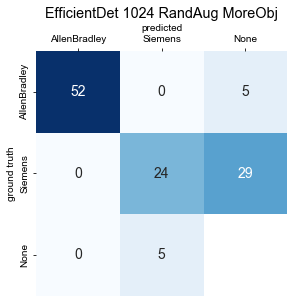

In [10]:
src.visualize.plot_detection_confusion_matrix(confMetrics,
                                              PATH_TO_LABELS,
                                              title='EfficientDet 1024 RandAug MoreObj',
                                              rotate_label = 90,
                                              save = None)

## 3.) Visual Evaluation

We list the paths to all the validation images:

In [29]:
IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMG_DIR,x) for x in os.listdir(PATH_TO_TEST_IMG_DIR) if '.jpg' in x or '.JPG' in x]

We can visualize the predictions on an arbitrary number of images using `src.visualize.plot_predictions_from_paths`.

Options:
* __target_size__ - resize the image to a smaller, square size if desired
* __min_score_thresh__ - only draw boxes with a detection score bigger than this threshold
* __img_per_row__ - determine how many images are plotted per row
* __linewidth__ - determine the linewidth of the boxes that get drawn

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]


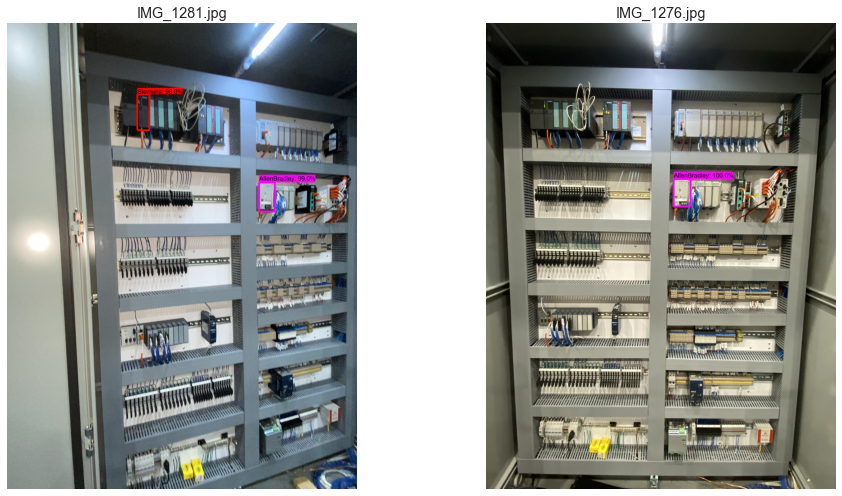

In [36]:
src.visualize.plot_predictions_from_paths(random.sample(IMAGE_PATHS,2),
                                          DETECT_FN,
                                          PATH_TO_LABELS,
                                          target_size = None,
                                          min_score_thresh = MIN_SCORE_THRESH,
                                          img_per_row = 2,
                                          linewidth = 16
                                         )

Alternatively, we can save high resolution images with drawn prediction boxes to a target directory with `src.visualize.save_predictions`:
    
Options:
* __target_dir__ - the folder where the images will be saved
* __target_size__ - resize the image to a smaller, square size if desired
* __min_score_thresh__ - only draw boxes with a detection score bigger than this threshold
* __linewidth__ - determine the linewidth of the boxes that get drawn

In [41]:
TARGET_DIR = 'evaluation-images'
if not Path(TARGET_DIR).exists():
    Path(TARGET_DIR).mkdir()
src.visualize.save_predictions(IMAGE_PATHS,
                 TARGET_DIR,
                 DETECT_FN,
                 PATH_TO_LABELS,
                 target_size = None,
                 min_score_thresh = MIN_SCORE_THRESH,
                 linewidth = 16
                )

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:39<00:00,  1.45it/s]
